In [3]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

In [ ]:
from sksurv.datasets import load_veterans_lung_cancer
df = pd.DataFrame(load_veterans_lung_cancer()[0])
va_x, va_y = load_veterans_lung_cancer()
df['Status'] = va_y['Status']
df['Survival in Days'] = va_y['Survival_in_days']

display(df.head())
print(pd.value_counts(df['Status']))
sns.pairplot(df, hue='Status', diag_kind="hist",markers=["o", "s"],
             x_vars=df.columns.drop('Status'),
             y_vars=df.columns.drop('Status'),
             corner=True)

Text(0.5, 0, 'time $t$')

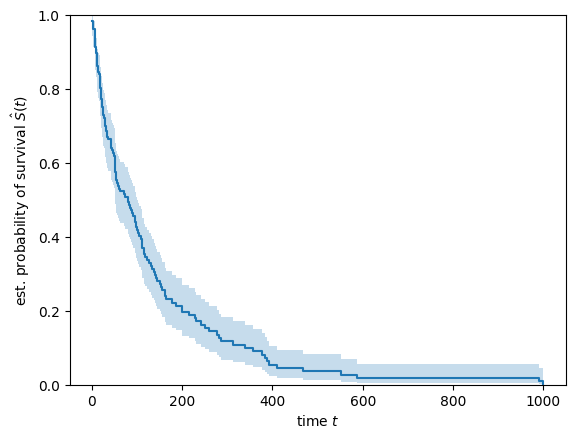

In [52]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    va_y["Status"], va_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

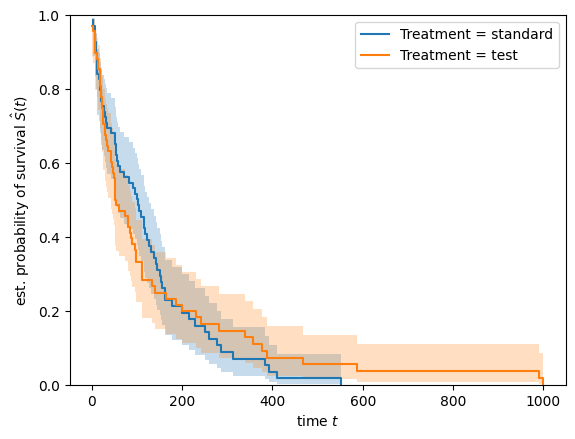

In [50]:
for treatment_type in ("standard", "test"):
    mask_treat = va_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        va_y["Status"][mask_treat],
        va_y["Survival_in_days"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Treatment = {treatment_type}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [64]:
data_x_numeric = OneHotEncoder().fit_transform(va_x)
display(data_x_numeric.head())

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis() #Cox predictor
estimator.fit(data_x_numeric, va_y)

pd.Series(estimator.coef_, index=data_x_numeric.columns)

print(estimator.score(data_x_numeric, va_y))
#Not great performance

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


0.7362562471603816


In [67]:
#Get feature importance
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_numeric.values, va_y)
print(pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False))

#grid search for best combination of features
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

pipe = Pipeline(
    [
        ("encode", OneHotEncoder()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

from sklearn.model_selection import GridSearchCV, KFold

param_grid = {"select__k": np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(va_x, va_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

pipe.set_params(**gcv.best_params_)
pipe.fit(va_x, va_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])
#We end up only using 5 parameters

Karnofsky_score          0.709280
Celltype=smallcell       0.572581
Celltype=large           0.561620
Celltype=squamous        0.550545
Treatment=test           0.525386
Age_in_years             0.515107
Months_from_Diagnosis    0.509030
Prior_therapy=yes        0.494434
dtype: float64


Celltype=large       -0.754714
Celltype=smallcell   -0.328059
Celltype=squamous    -1.147673
Karnofsky_score      -0.031112
Treatment=test        0.257313
dtype: float64

In [98]:
data_x_featSelect = data_x_numeric[np.array(encoder.encoded_columns_[transformer.get_support()])]
display(data_x_featSelect)
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis() #Cox predictor
estimator.fit(data_x_featSelect, va_y)

pd.Series(estimator.coef_, index=data_x_featSelect.columns)

print(estimator.score(data_x_featSelect, va_y))
#Only Slight Improvement

,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Treatment=test
0,0.0,0.0,1.0,60.0,0.0
1,0.0,0.0,1.0,70.0,0.0
2,0.0,0.0,1.0,60.0,0.0
3,0.0,0.0,1.0,60.0,0.0
4,0.0,0.0,1.0,70.0,0.0
...,...,...,...,...,...
132,1.0,0.0,0.0,75.0,1.0
133,1.0,0.0,0.0,60.0,1.0
134,1.0,0.0,0.0,70.0,1.0
135,1.0,0.0,0.0,80.0,1.0


0.7370513402998637


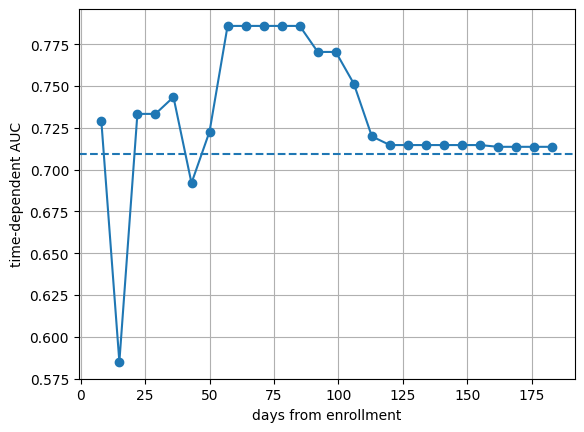

In [101]:
from sksurv.ensemble import RandomSurvivalForest

va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    va_x, va_y, test_size=0.2, stratify=va_y['Status'], random_state=0
)

rsf = make_pipeline(OneHotEncoder(), RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0))
rsf.fit(va_x_train, va_y_train)

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x_train, va_y_train)

va_times = np.arange(8, 184, 7)
cph_risk_scores = cph.predict(va_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

## Model Analysis:
The plot shows that the model is doing moderately well on average with an AUC of ~0.72 (dashed line). However, there is a clear difference in performance between the first and second half of the time range. The performance on the test data increases up to 56 days from enrollment, remains high until 98 days and quickly drops thereafter. Thus, we can conclude that the model is most effective in predicting death in the medium-term.

## Using Time-dependent Risk Scores

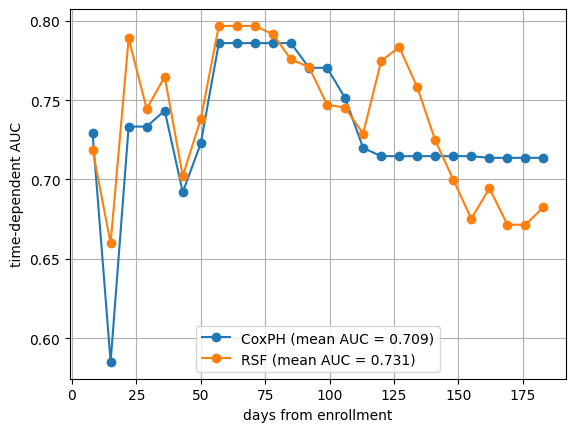

In [102]:
rsf = make_pipeline(OneHotEncoder(), RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0))
rsf.fit(va_x_train, va_y_train)

rsf_chf_funcs = rsf.predict_cumulative_hazard_function(va_x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, rsf_risk_scores, va_times)

plt.plot(va_times, cph_auc, "o-", label=f"CoxPH (mean AUC = {cph_mean_auc:.3f})")
plt.plot(va_times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

We see overall better performance that follows generally the same trend when looking at the time-independent model, however we see worse performance at the higher values of survival time.

## Time-dependent Brier Score

In [109]:
data_x_numeric = OneHotEncoder().fit_transform(va_x)
va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    data_x_numeric, va_y, test_size=0.2, stratify=va_y['Status'], random_state=0
)

rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(va_x_train, va_y_train)

cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
cph_gbsg.fit(va_x_train, va_y_train)

#Compare Survival forests to cox

score_cindex = pd.Series(
    [
        rsf_gbsg.score(va_x_test, va_y_test),
        cph_gbsg.score(va_x_test, va_y_test),
        0.5,
    ],
    index=["RSF", "CPH", "Random"],
    name="c-index",
)

# display(score_cindex.round(3)) #Slightly better performance in CPH

lower, upper = np.percentile(va_y["Survival_in_days"], [10, 90]) # look between 0% and 90% percentile of observed time points.
gbsg_times = np.arange(lower, upper + 1)

rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(va_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in cph_gbsg.predict_survival_function(va_x_test)])
random_surv_prob = 0.5 * np.ones((va_y_test.shape[0], gbsg_times.shape[0]))

km_func = StepFunction(*kaplan_meier_estimator(va_y_test["Status"], va_y_test["Survival_in_days"]))
km_surv_prob = np.tile(km_func(gbsg_times), (va_y_test.shape[0], 1))

score_brier = pd.Series(
    [
        integrated_brier_score(va_y, va_y_test, prob, gbsg_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
RSF,0.599,0.181
CPH,0.647,0.169
Random,0.500,0.246
Kaplan-Meier,NaN,0.181


Despite Random Survival Forest and Cox’s proportional hazards model performing equally well in terms of discrimination (c-index), there seems to be a notable difference in terms of calibration (IBS), with Cox’s proportional hazards model outperforming Random Survival Forest.

## Using Metrics in Hyper-parameter Search

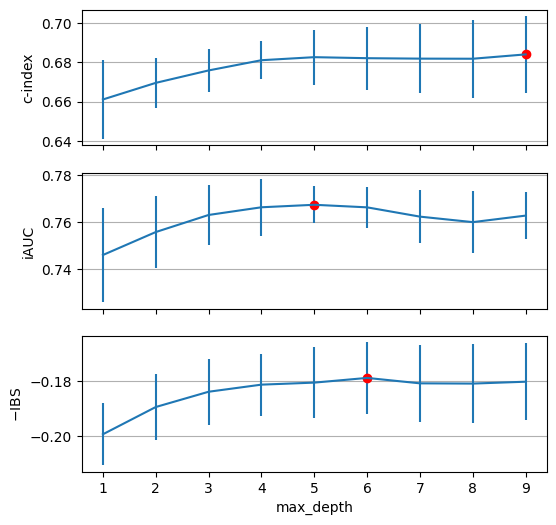

In [123]:
from sklearn.model_selection import GridSearchCV, KFold

from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

gbsg_X, gbsg_y = load_gbsg2() # new data set, was getting Nans with the old one
gbsg_X = encode_categorical(gbsg_X)

gbsg_X_train, gbsg_X_test, gbsg_y_train, gbsg_y_test = train_test_split(
    gbsg_X, gbsg_y, stratify=gbsg_y["cens"], random_state=1
)

rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(gbsg_X_train, gbsg_y_train)

cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
cph_gbsg.fit(gbsg_X_train, gbsg_y_train)

score_cindex = pd.Series(
    [
        rsf_gbsg.score(gbsg_X_test, gbsg_y_test),
        cph_gbsg.score(gbsg_X_test, gbsg_y_test),
        0.5,
    ],
    index=["RSF", "CPH", "Random"],
    name="c-index",
)
lower, upper = np.percentile(gbsg_y["time"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(gbsg_X_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in cph_gbsg.predict_survival_function(gbsg_X_test)])
random_surv_prob = 0.5 * np.ones((gbsg_y_test.shape[0], gbsg_times.shape[0]))

km_func = StepFunction(*kaplan_meier_estimator(gbsg_y_test["cens"], gbsg_y_test["time"]))
km_surv_prob = np.tile(km_func(gbsg_times), (gbsg_y_test.shape[0], 1))
score_brier = pd.Series(
    [
        integrated_brier_score(gbsg_y, gbsg_y_test, prob, gbsg_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

cv = KFold(n_splits=3, shuffle=True, random_state=1)

cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}

gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(rsf_gbsg, tau=gbsg_times[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(rsf_gbsg, times=gbsg_times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

gcv_ibs = GridSearchCV(
    as_integrated_brier_score_scorer(rsf_gbsg, times=gbsg_times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

def plot_grid_search_results(gcv, ax, name):
    ax.errorbar(
        x=gcv.cv_results_["param_estimator__max_depth"].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["estimator__max_depth"],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)


_, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axs[-1].set_xlabel("max_depth")

plot_grid_search_results(gcv_cindex, axs[0], "c-index")
plot_grid_search_results(gcv_iauc, axs[1], "iAUC")
plot_grid_search_results(gcv_ibs, axs[2], "$-$IBS")

When optimizing for the concordance index, a high maximum depth works best, whereas the other metrics are best when choosing a maximum depth of 5 and 6, respectively.

## Penalized Cox


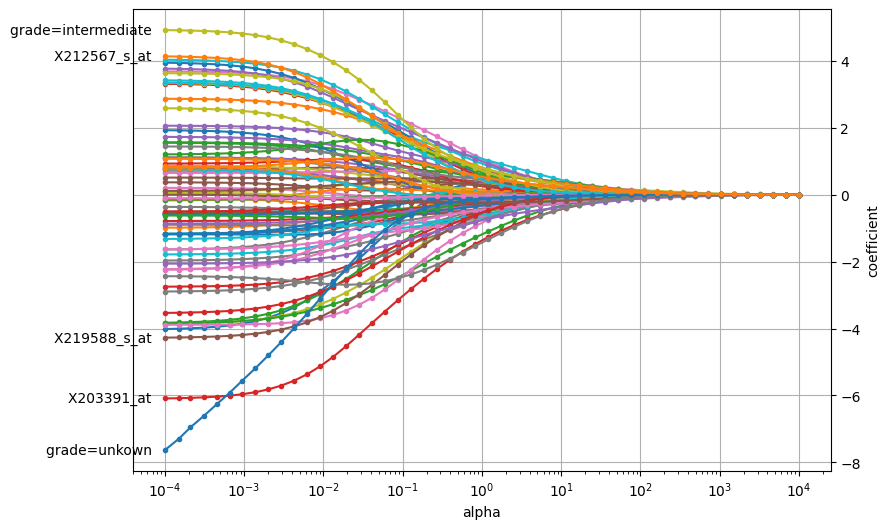

In [127]:
#Ridge
from sksurv.datasets import load_breast_cancer

#Load Data
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

#Fit model
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    
plot_coefficients(coefficients, n_highlight=5)

We can see that if the penalty has a large weight (to the right), all coefficients are shrunk almost to zero. As the penalty’s weight is decreased, the coefficients’ value increases. We can also observe that the paths for X203391_at and tumor grade quickly separate themselves from the remaining coefficients, which indicates that this particular gene expression level and tumor grade are important predictive factors for time to distant metastasis.

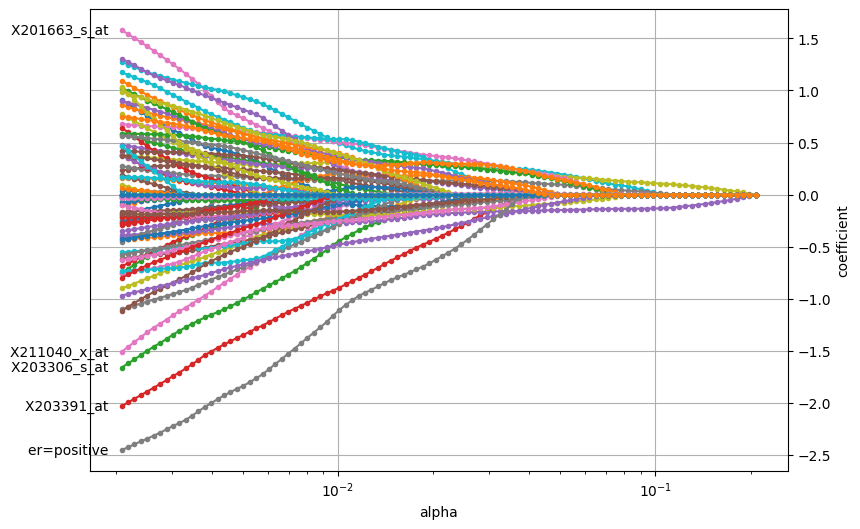

In [128]:
#Lasso
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))
plot_coefficients(coefficients_lasso, n_highlight=5)

The figure shows that the LASSO penalty indeed selects a small subset of features for large (to the right) with only two features (purple and yellow line) being non-zero. As  decreases, more and more features become active and are assigned a non-zero coefficient until the entire set of features is used (to the left left). Similar to the plot above for the ridge penalty, the path for X203391_at stands out, indicating its importance in breast cancer. However, the overall most important factor seems to be a positive estrogen receptor status (er).

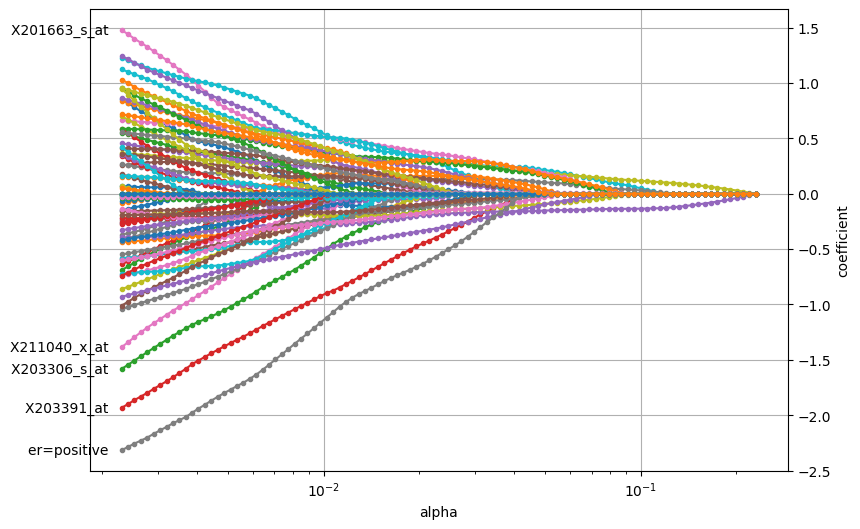

In [129]:
#Elastic Net
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

Choosing an $\alpha$

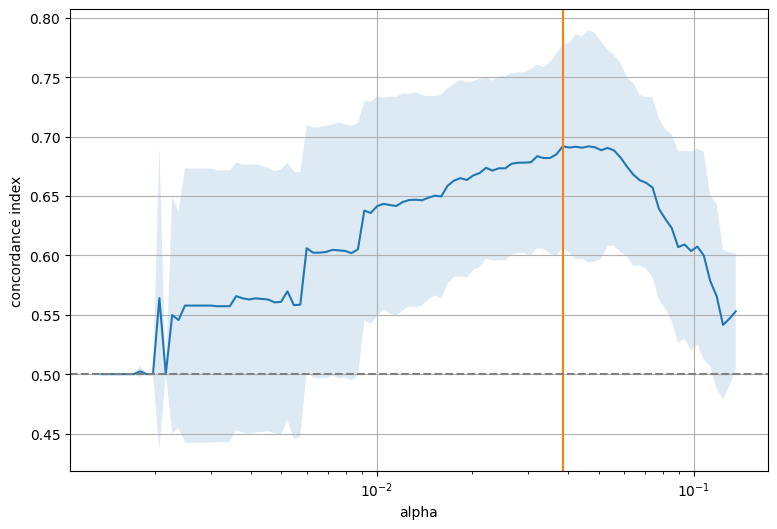

In [131]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

The figure shows that there is a range for to the right where it is too large and sets all coefficients to zero, as indicated by the 0.5 concordance index of a purely random model. On the other extreme, if  becomes too small, too many features enter the model and the performance approaches that of a random model again. The sweet spot (orange line) is somewhere in the middle. Let’s inspect that model

Number of non-zero coefficients: 22


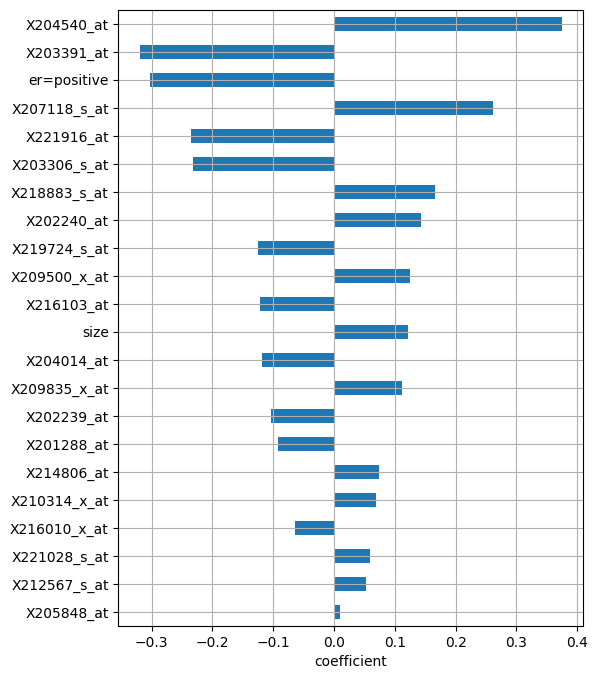

In [132]:
#Fit best Model and show variable weights 
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

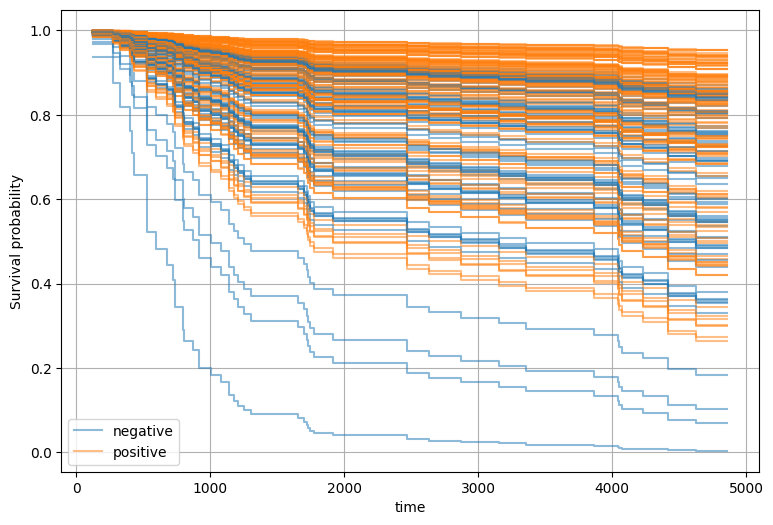

In [133]:
#Survival and Cumulative Hazard Function
#Perform Predictions
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)


# EX:  select a patient and determine how positive or negative
# estrogen receptor status would affect the survival function.
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["t.tdm"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, "er=positive"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

#We can observe that patients with positive estrogen receptor status tend to have a better prognosis.

## Random Survival Forests

Tree based learner

0.6759696016771488


,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64


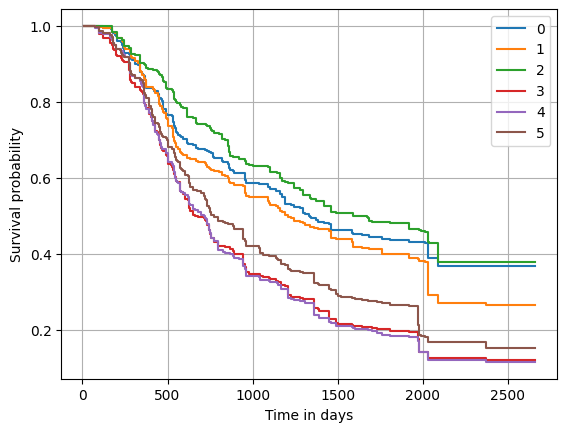

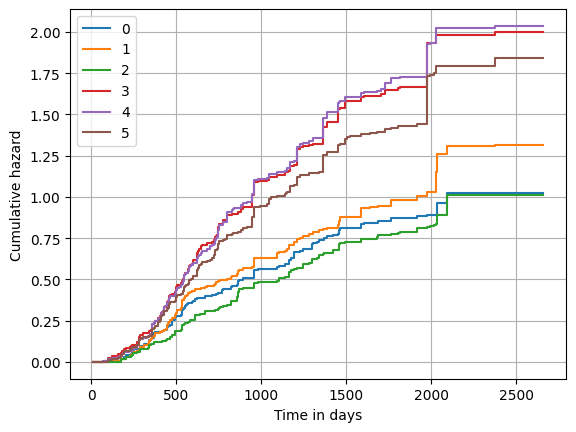

In [136]:
from sklearn.preprocessing import OrdinalEncoder

X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

#Training
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

print(rsf.score(X_test, y_test))

#Predicting
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

display(X_test_sel)
print(pd.Series(rsf.predict(X_test_sel)))

#Survival Function
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.show()


#Cummulative Hazard Function
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [137]:
#Permutation-based Feature Importance 
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
pnodes,0.076616,0.019106
age,0.016562,0.008774
progrec,0.011513,0.013504
horTh=yes,0.008220,0.004313
tgrade,0.004831,0.003773
tsize,0.002542,0.008665
menostat=Post,-0.000087,0.000978
estrec,-0.007206,0.009461


## Gradient Boosted Models

0.765


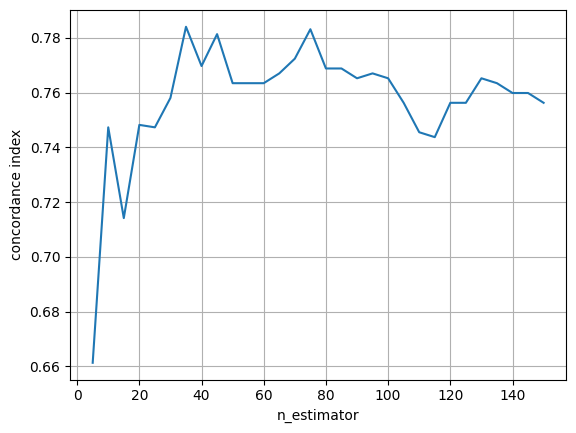

Number of non-zero coefficients: 9
er=positive          -0.837549
X207118_s_at          0.239161
grade=unkown         -0.234126
size                  0.214384
X204540_at            0.094421
X204014_at           -0.091377
X216103_at           -0.086147
X221916_at           -0.081565
grade=intermediate    0.065916
dtype: float64


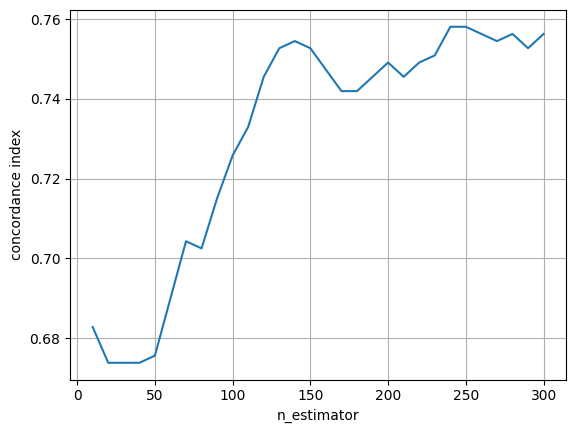

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=0)

#using gradient boosting on Cox’s partial likelihood with regression
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3)) #Base to compare to


#Vary n_estimators
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)
    
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)
plt.show()

#Performance improves until ensamble becomes too large

#Repeat with component-wise least squares base learners
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)
    
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True) #slower increase and worse max performanse

#ceofs
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
print(coef_nz.loc[coef_order])

## Accelrated Faillure Time Model
Alternative to Cox’s proportional hazards model
Features in an AFT model can accelerate or decelerate the time to an event by a constant factor.
Hazard remains constant for the proportional hazards model and varies for the AFT model.

In [140]:
# loss="ipcwls" give AFT

est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.722


### Regularization
Combatting overfitting

Use a learning_rate less than 1 to restrict the influence of individual base learners, similar to the Ridge penalty.

Use a non-zero dropout_rate, which forces base learners to also account for some of the previously fitted base learners to be missing.

Use subsample less than 1 such that each iteration only a portion of the training data is used. This is also known as stochastic gradient boosting.

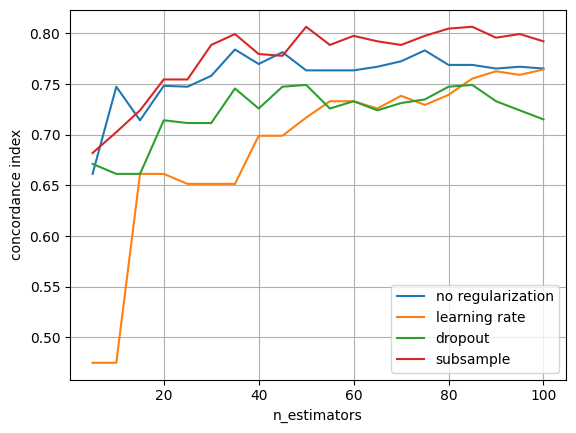

In [142]:
#Regularization
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

Fitted base learners: 119
Performance on test set 0.703


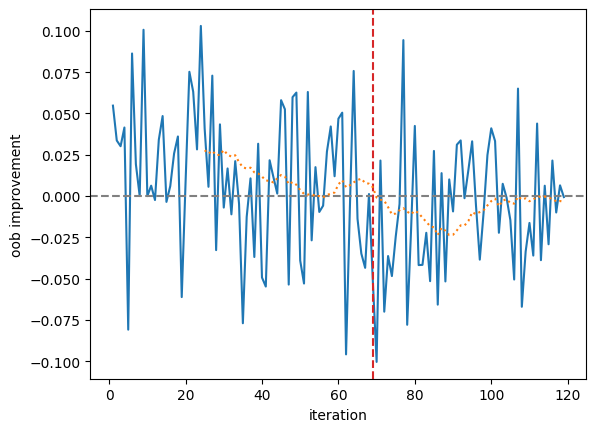

In [143]:
#Method to stop training if score does not improve

class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

improvement = pd.Series(
    est_early_stopping.oob_improvement_, index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

## Survival Support Vector Machines

Survival analysis in the context of Support Vector Machines can be described in two different ways:

As a ranking problem: the model learns to assign samples with shorter survival times a lower rank by considering all possible pairs of samples in the training data.

As a regression problem: the model learns to directly predict the (log) survival time.

6.6% of records are censored
[-1.59  -1.687]
[( True,  72.) ( True, 411.)]


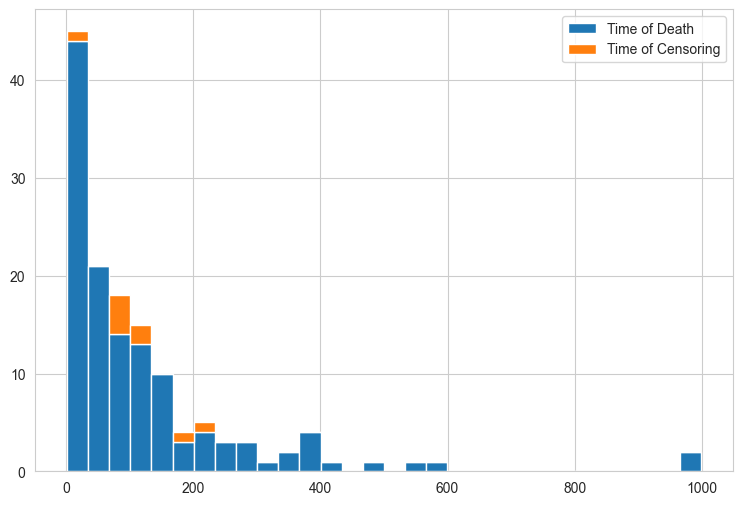

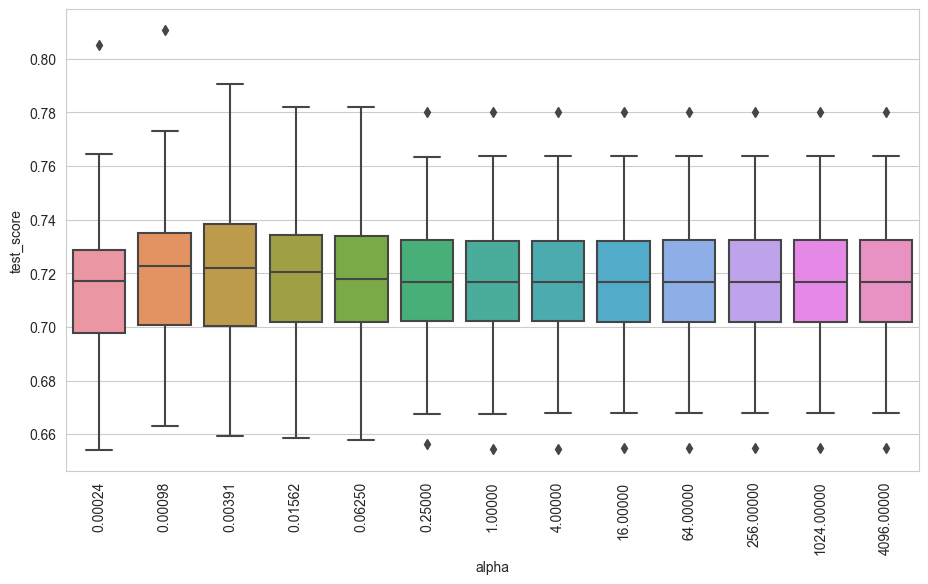

In [144]:
#Linear SVMS
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

n_censored = y.shape[0] - y["Status"].sum()
print(f"{n_censored / y.shape[0] * 100:.1f}% of records are censored")

plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist(
    (y["Survival_in_days"][y["Status"]], y["Survival_in_days"][~y["Status"]]), bins=30, stacked=True
)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

#Initial Estimator
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

#Evaluation Metric: Harrell's concordance index
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Status"], y["Survival_in_days"], prediction)
    return result[0]

#Set of parameters we want to try and how many reps we are performing
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, n_jobs=1, refit=False, cv=cv)

#Start Hyper parameter search\
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)
round(gcv.best_score_, 3), gcv.best_params_ #best avg performance

#Retrieve all scores for each paramter and visualize
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        name = f'{params["alpha"]:.5f}'
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_[f"split{j}_test_score"][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")
    
plot_performance(gcv)

#Fit using best alpha
estimator.set_params(**gcv.best_params_)
estimator.fit(x, y)

#Prediction
pred = estimator.predict(x.iloc[:2])
print(np.round(pred, 3))
print(y[:2])


In [145]:
#Regression objective
#Use r=0 

ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(x, y)

cindex = concordance_index_censored(
    y["Status"],
    y["Survival_in_days"],
    -ref_estimator.predict(x),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

pred = ref_estimator.predict(x.iloc[:2])
print(np.round(pred, 3)) #Similar Results

0.736
[120.786 149.963]


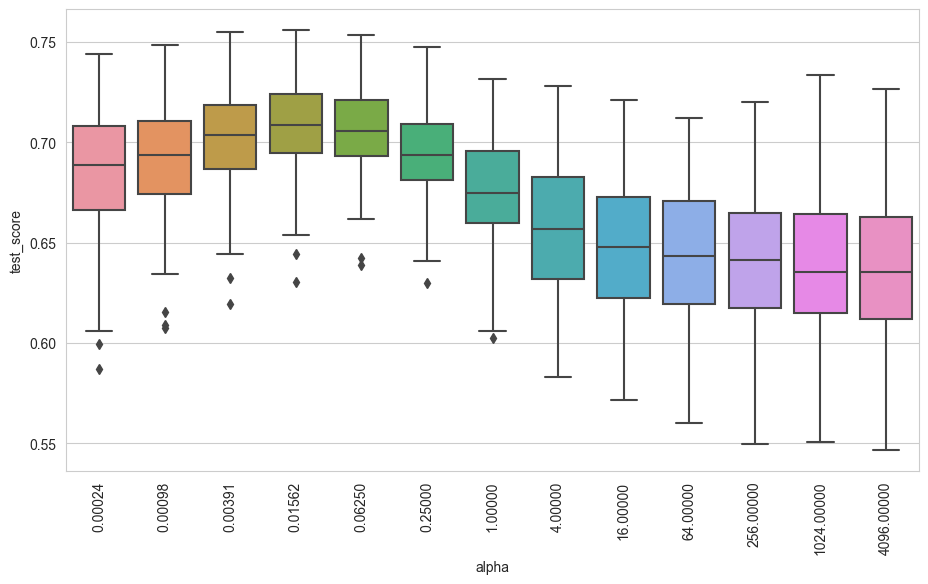

In [146]:
#Kernel SVMS
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM

kernel_matrix = clinical_kernel(data_x)

#find optimal alpha via grid search

kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)
#when using a custom kernel, we do not pass the original data (data_x) to the fit function, but the pre-computed, square kernel matrix.

kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model, n_jobs=1, refit=False, cv=cv)

kgcv = kgcv.fit(kernel_matrix, y)

round(kgcv.best_score_, 3), kgcv.best_params_

plot_performance(kgcv)

We can see that the choice of $\alpha$ is much more important here, compared to the Linear Survival Support Vector Machine. Nevertheless, the best performance is below that of the linear model, which illustrates that choosing a good kernel function is essential, but also a non-trivial task.